# Model tester
Ejecución de predicciones de pruebas para validar el modelo entrenado.

Referencias: 
*  https://keras.io/examples/vision/super_resolution_sub_pixel/
*  https://pyimagesearch.com/2021/09/27/pixel-shuffle-super-resolution-with-tensorflow-keras-and-deep-learning/

Importamos las librerías necesarias.

In [1]:
import os
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

from PIL import Image
import cv2 as cv2

Bloque de configuración:

In [2]:
# root path
ROOT_PATH = 'C:\\_pfm'

# specific paths
TEST_SET = os.path.join(ROOT_PATH, 'img', 'test')
SAVED_MODEL = os.path.join(ROOT_PATH, 'model')

# specify the initial size of the images and downsampling factor
ORIG_SIZE = (300, 300)
DOWN_FACTOR = 3


Funciones varias necesarias para validar el modelo.

In [3]:
# Función que calcula el PSNR (Peak Signal to Noise Ratio). Usaremos el PSNR como métrica de nuestro modelo

def psnr(orig, pred):
    # cast the target images to integer
    orig = orig * 255.0
    orig = tf.cast(orig, tf.uint8)
    orig = tf.clip_by_value(orig, 0, 255)

    # cast the predicted images to integer
    pred = pred * 255.0
    pred = tf.cast(pred, tf.uint8)
    pred = tf.clip_by_value(pred, 0, 255)
    
    # return the psnr
    return tf.image.psnr(orig, pred, max_val=255)


### Predicción

In [4]:
# Función que toma la ruta de una imagen y la devuelve reducida (con los mismos canales)

def load_image(imagePath):
    # load image from disk and downsample it using the bicubic method
    orig = load_img(imagePath)
    downsampled = orig.resize((orig.size[0] // DOWN_FACTOR, orig.size[1] // DOWN_FACTOR), Image.BICUBIC)
    
    # return a tuple of the original and downsampled image
    return (orig, downsampled)


In [5]:
# Función que obtiene el canal Y de la imagen

def get_y_channel(image):
    # convert the image to YCbCr colorspace and then split it to get the
    # individual channels
    ycbcr = image.convert("YCbCr")
    (y, cb, cr) = ycbcr.split()
    
    # convert the y-channel to a numpy array, cast it to float, and
    # scale its pixel range to [0, 1]
    y = np.array(y)
    y = y.astype("float32") / 255.0
    
    # return a tuple of the individual channels
    return (y, cb, cr)


In [6]:
# Función que aplica el reescalado de la imagen de [0,1] a [0,255] (canal Y)

def clip_numpy(image):
    # cast image to integer, clip its pixel range to [0, 255]
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.clip_by_value(image, 0, 255).numpy()
    
    # return the image
    return image


In [7]:
# Función que convierte la imagen YUV a RGB.

def postprocess_image(y, cb, cr):
    # do a bit of initial preprocessing, reshape it to match original size, and then convert it to a PIL Image
    y = clip_numpy(y).squeeze()
    y = y.reshape(y.shape[0], y.shape[1])
    y = Image.fromarray(y, mode="L")
    
    # resize the other channels of the image to match the original dimension
    outputCB= cb.resize(y.size, Image.BICUBIC)
    outputCR= cr.resize(y.size, Image.BICUBIC)
    
    # merge the resized channels altogether and return it as a numpy array
    final = Image.merge("YCbCr", (y, outputCB, outputCR)).convert("RGB")
    return np.array(final)


In [8]:
# sharpen

def sharpen(img):
    #sharpen_filter = np.array([
    #    [0, -1, 0],
    #    [-1, 5, -1],
    #    [0, -1, 0]
    #])
    sharpen_filter = np.array([
        [1,   4,    6,   4,  1],
        [4,  16,   24,  16,  4],
        [6,  24, -476,  24,  6],
        [4,  16,   24,  16,  4],
        [1,   4,    6,   4,  1]
    ])

    sharpen_filter = -1 * sharpen_filter / 256
    sharpen_img = cv2.filter2D(img, -1, sharpen_filter)
    
    return sharpen_img


[INFO] loading test images...
[INFO] loading model...
[INFO] performing predictions...


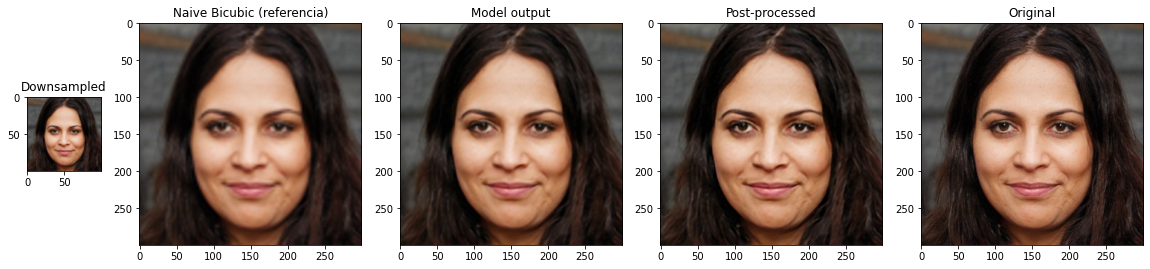

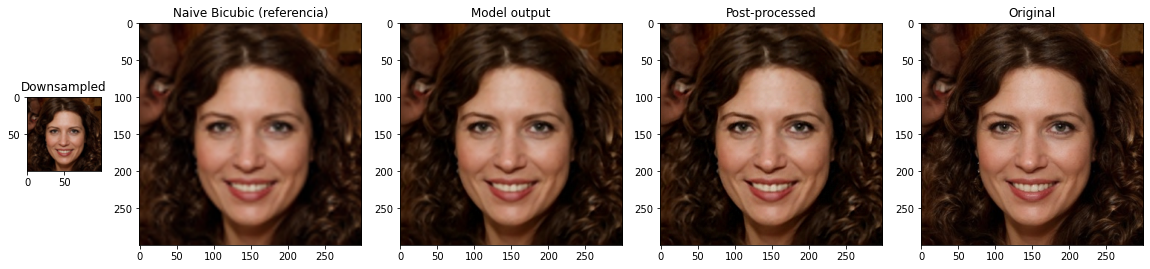

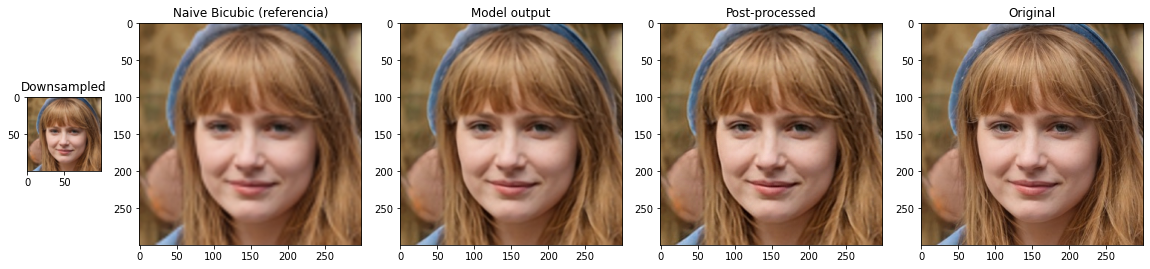

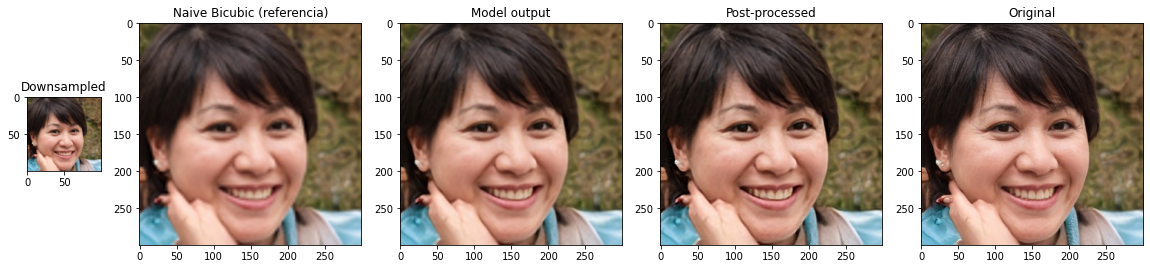

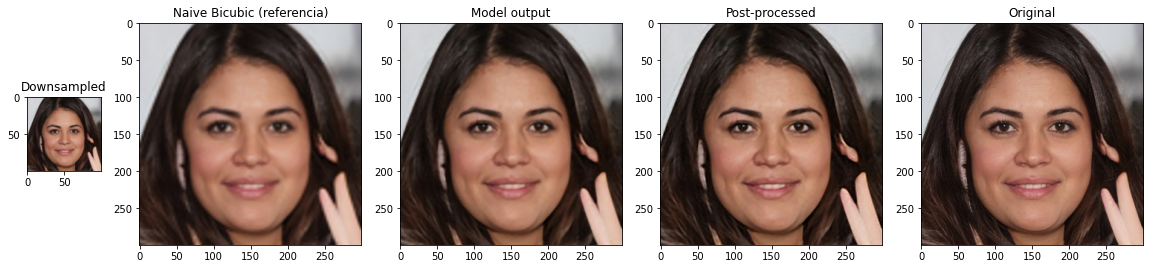

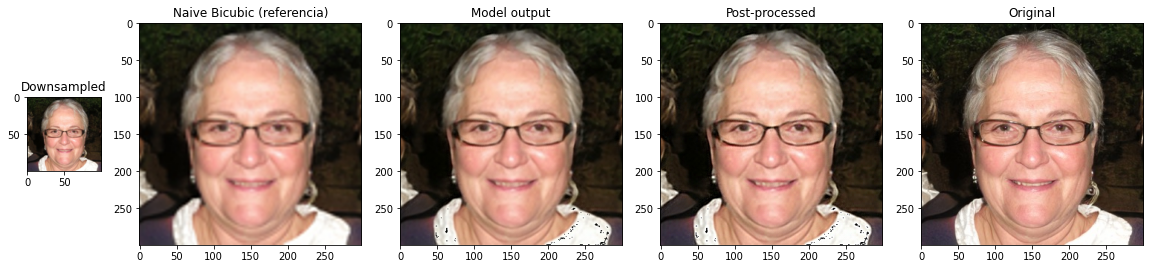

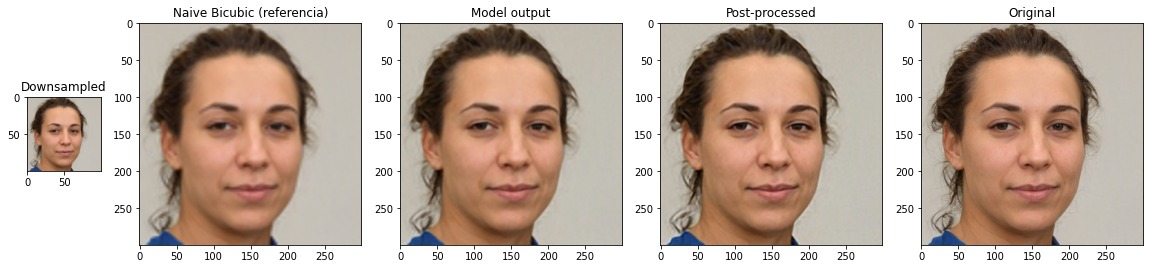

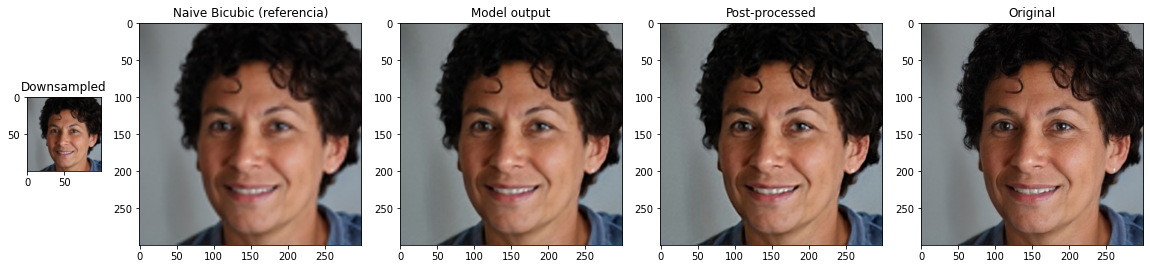

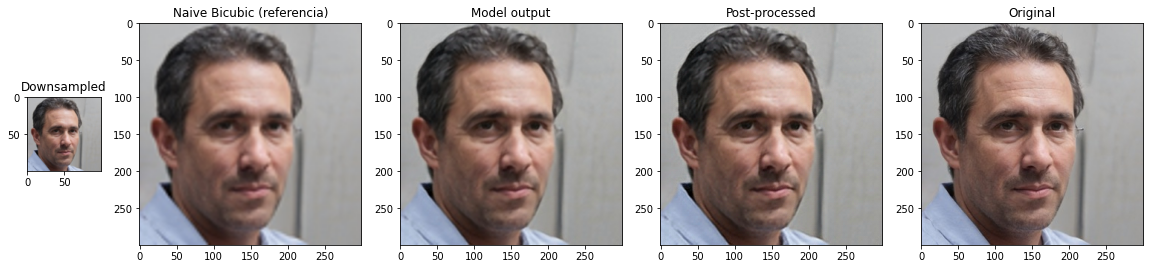

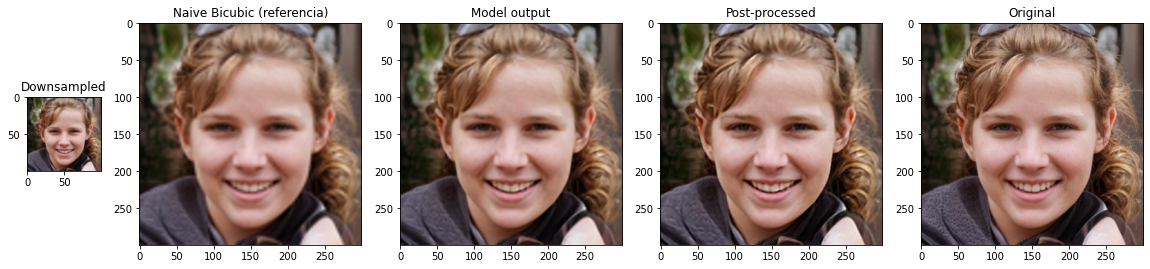

In [9]:
# load the test image paths from disk and select ten paths randomly
print("[INFO] loading test images...")
testPaths = list(paths.list_images(TEST_SET))
currentTestPaths = np.random.choice(testPaths, 10)
#currentTestPaths = np.random.choice(testPaths, 1)

# load our super-resolution model from disk
print("[INFO] loading model...")
superResModel = load_model(SAVED_MODEL, custom_objects={"psnr" : psnr})

# iterate through our test image paths
print("[INFO] performing predictions...")
for (i, path) in enumerate(currentTestPaths):
    # grab the original and the downsampled images from the current path
    (orig, downsampled) = load_image(path)
    
    # retrieve the individual channels of the current image and perform inference
    (y, cb, cr) = get_y_channel(downsampled)
    upscaledY = superResModel.predict(y[None, ...])[0]
    
    # postprocess the output and apply the naive bicubic resizing to the downsampled image for comparison
    finalOutput = postprocess_image(upscaledY, cb, cr)
    naiveResizing = downsampled.resize(orig.size, Image.BICUBIC)

    # Resaltar bordes para aumentar la nitidez
    finalPost = sharpen(finalOutput)

    # visualize the results
    (fig, ax) = plt.subplots(ncols=5, figsize=(20, 40), gridspec_kw={'width_ratios': [1, 3, 3, 3, 3]})
    ax[0].set_title("Downsampled")
    ax[0].imshow(downsampled)
    ax[0].grid(False)
    
    ax[1].set_title("Naive Bicubic (referencia)")
    ax[1].imshow(naiveResizing)
    ax[1].grid(False)
    
    ax[2].set_title("Model output")
    ax[2].imshow(finalOutput.astype("int"))
    ax[2].grid(False)
    
    ax[3].set_title("Post-processed")
    ax[3].imshow(finalPost.astype("int"))
    ax[3].grid(False)
    
    ax[4].set_title("Original")
    ax[4].imshow(orig)
    ax[4].grid(False)

    #fig.savefig(path, dpi=300, bbox_inches="tight")
    
    #break    ###
          

Text(0.5, 1.0, 'Salida +filtrado')

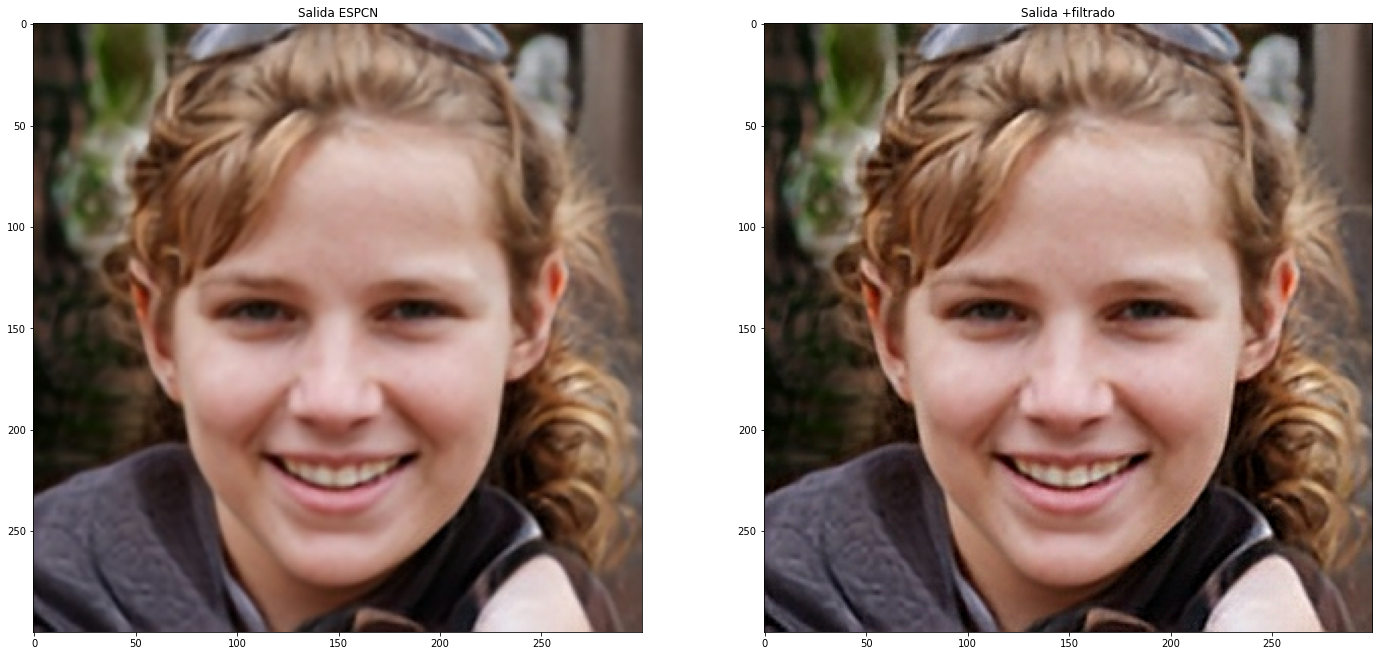

In [10]:
## Post-proceso. Aumentamos la nitidez de la imagen
    
(fig, (ax1, ax4)) = plt.subplots(ncols=2, figsize=(24, 32))
#ax1.imshow(orig)
ax1.imshow(finalOutput)
ax4.imshow(finalPost.astype("int"))
ax1.set_title("Salida ESPCN")
ax4.set_title("Salida +filtrado")